![](images/notebook-images/random-forest-bike-rentals/bike-sharing_stephane-mingot_unsplash.jpg){fig-align="center"}

<center><a href = "https://unsplash.com/photos/e8msPzLTXxU">Unsplash | Stéphane Mingot</a></center>

# Introduction

Regression models refer to a class of machine learning models that predict continuous variables. That is, they predict quantities such as the count of an object, its price, its size, its mass, etc. This is what makes regression models different from classification models, which predict discrete categories such as positive and negative test results, survival or death, place of origin, etc.

In this project, I will compare three different regression models: linear regression, decision tree, and random forest. I will use these to predict the number of people who will rent a bike from the bike sharing stations in Washington, D.C. at a given hour of a given day. I will then compare the performance of these models and discuss the factors that may have affected their performance.

:::{.callout-note}

I wrote this notebook by following a guided project on the [Dataquest](https://www.dataquest.io/) platform, specifically the [Guided Project: Predicting Bike Rentals](https://app.dataquest.io/c/22/m/213/guided-project%3A-predicting-bike-rentals/1/introduction-to-the-dataset). The general project flow and research questions were guided by Dataquest. Other than what was instructed, I also added my own steps. You can visit the [official solution](https://github.com/dataquestio/solutions/blob/master/Mission213Solution.ipynb) to compare it to my project.

:::

Below are the packages imported for this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Custom modules
from custom_modules import linreg_tools as lrt

Note that some of the imported modules are custom ones that I wrote. To view these modules, visit this [directory](https://github.com/MiguelAHG/migs-germar-data-science-blog/tree/main/posts/custom_modules) in my website's repository.

# The Dataset

The "Bike Sharing Dataset" was donated to the UCI Machine Learning Repository by Hadi Fanaee-T in 2013. It contains data on bike rentals in Washington, D.C. from 2011-2012. The first 5 rows of the data are shown below.

In [2]:
#| code-fold: true
data = pd.read_csv("./private/Bike-Rentals-Files/hour.csv")

data.dteday = pd.to_datetime(data.dteday)

data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Each row contains data for one hour of a certain day. The `dteday` column shows the date, and the `hr` column shows the hour from 0 (midnight) to 23 (11:00 PM). Also, the `instant` column provides an identification number for each row.

The `cnt` variable shows the total number of people who rented bikes during a given hour. It is the sum of the `casual` (casual renters) and `registered` (registered renters) variables. The other variables describe conditions like the weather.

For more information on the variables, one can visit the [data documentation](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) and scroll down to "Attribute Information". Note that this link is also the link from which I downloaded the dataset.

Let us look at a summary of the variables.

In [3]:
#| code-fold: true
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

The summary above shows that there are 17,379 rows and 17 columns. None of the rows have null values. Furthermore, all of the columns have numeric data types, with the exception of `dteday`, which contains datetime values.

However, according to the documentation, the following variables are nominal or ordinal despite being numeric:

- `instant` provides an ID number to each entry.
- `season` ranges from winter (1) to fall (4).
- `holiday` contains values of 1 if the day is a holiday, else 0.
- `workingday` contains values of 1 if the day is neither a holiday nor weekday, else 0.
- `weathersit` ranges from 1 (mild weather) to 4 (certain extreme weather conditions).

`instant` should not be used as a predictor variable, but the others may be used. I must keep in mind, however, that linear regression treats all variables as continuous. It assumes that each one-unit change in a predictor variable increases or decreases the target variable by a set amount.

Another concern is the `hr` variable, which indicates the hour of the day from 0 (midnight) to 23 (11:00 PM). This variable is rather fine-grained, and it would be interesting to experiment with creating a new variable that groups certain hours together. That is, 1 would refer to the morning, 2 to the afternoon, 3 to the evening, and 4 to night time.

This variable has been created below, and it has been named `time_label`.

In [4]:
#| code-fold: true
# Make time_label column

def hour_to_label(h):
    """Convert an integer representing an hour of the day to an integer representing a section of the day-night cycle.
    1: morning, 2: afternoon, 3: evening, 4: night."""
    if h >= 6 and h < 12:
        return 1
    elif h >= 12 and h < 18:
        return 2
    elif h >= 18 and h < 24:
        return 3
    elif h >= 0 and h < 6:
        return 4

data["time_label"] = data.hr.apply(hour_to_label)

data[["hr", "time_label"]].head()

,hr,time_label
0,0,4
1,1,4
2,2,4
3,3,4
4,4,4


The table above shows the first 5 rows and the `hr` and `time_label` columns. Since the hours from 00:00 to 04:00 occur in the middle of the night, the `time_label` values are 4.

Now, data inspection and cleaning are done, so I can move on to the models.

# Linear Regression

The first of the three models is linear regression. It attempts to determine how predictors affect the target variable by assigning each predictor a coefficient. The coefficients are then used in an equation to come up with a predicted value for a new observation.

Note that I may not go into full detail about the steps that I am performing. To know more about the details, view my other [post](2021-12-28-Linear-Regression-House-Prices.ipynb) on linear regression for predicting house sale prices.

## Feature Selection

I must select features that have a useful linear relationship with the number of bike rentals (`cnt`). The code cell below lists the initial list of features that I will consider. I will not use `casual` and `registered` since these are systematically related to `cnt`.

In [5]:
considered_features = pd.Series([
    "season",
    "yr",
    "mnth",
    "hr",
    "time_label",
    "holiday",
    "weekday",
    "workingday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed",
])

First, I can find the Pearson's correlation coefficient between each variable and the target.

In [6]:
#| code-fold: true
target_col = "cnt"

# Correlation coefficient of each variable with cnt
cnt_corr = (
    data
    .loc[:, considered_features.tolist() + [target_col]]
    .corr()
    .loc[:, "cnt"]
    .drop(index = "cnt")
    # Sort by distance from 0
    .sort_values(key = np.abs, ascending = False)
)

print("Correlation Coefficient of each Variable with `cnt`")
cnt_corr

Correlation Coefficient of each Variable with `cnt`


temp          0.404772
atemp         0.400929
hr            0.394071
time_label   -0.378318
hum          -0.322911
yr            0.250495
season        0.178056
weathersit   -0.142426
mnth          0.120638
windspeed     0.093234
holiday      -0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

The coefficients have been ordered by distance from 0, descending. Coefficients farther from 0 indicate stronger correlation.

It appears that the temperature (`temp`) and feeling temperature (`atemp`) have the strongest correlation with bike rentals, so it is likely that these will be significant predictors.

As for the other variables, I will not drop any of them based solely on their correlation coefficient. This decision may seem strange since some variables have very weak correlations, even less than 0.10. However, one must note that these coefficients are the results of univariate tests. It is still possible for a variable to become significant when the effects of other variables are taken into consideration in multiple linear regression. Furthermore, the sample size is large (n = 17379), so there is little risk of overfitting from having too many predictors.

However, I do have to drop predictors if they have multicollinearity issues. Thus, I have generated a correlation heatmap to inspect correlations among predictors.

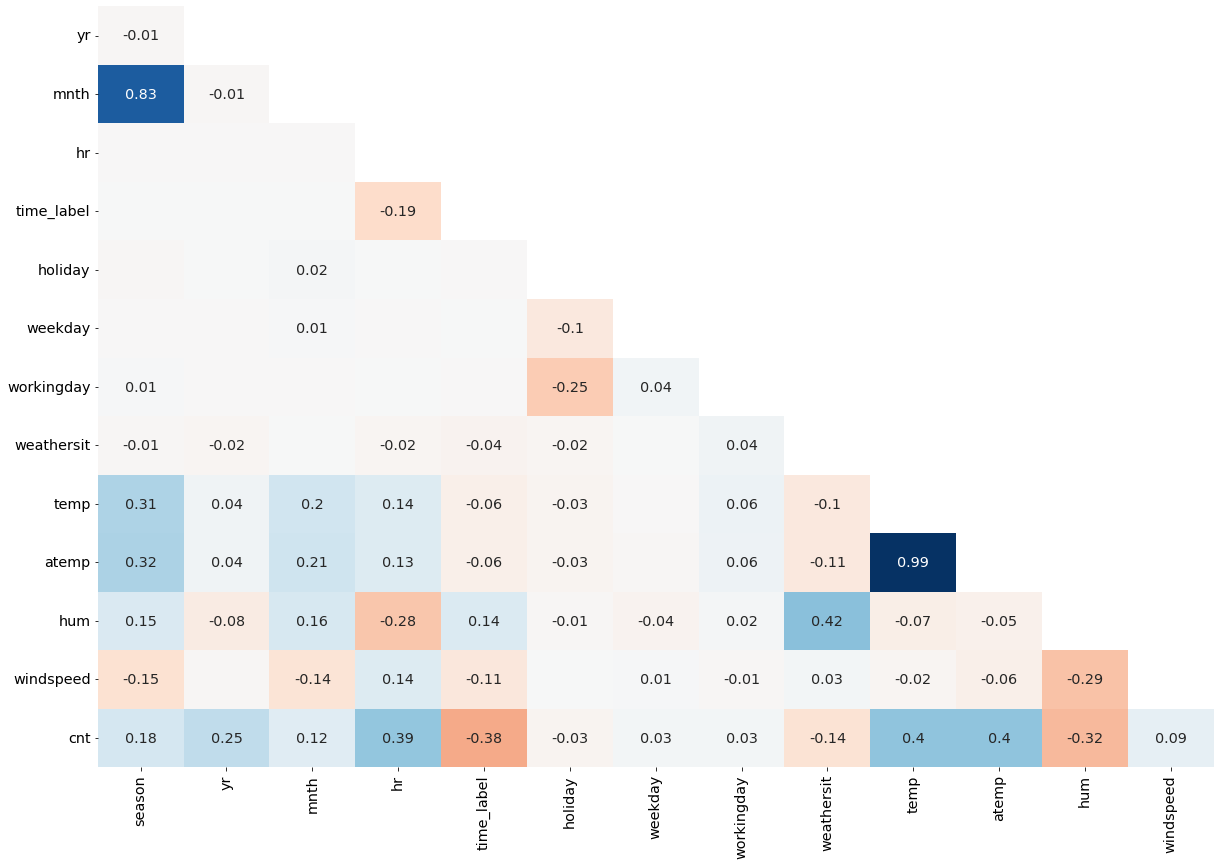

In [7]:
#| code-fold: true
lrt.correlation_heatmap(data[considered_features.tolist() + [target_col]].corr())

In the heatmap above, blue represents positive correlations, red represents negative correlations, and darker shades represent stronger correlations.

It appears that `temp` and `atemp` are highly correlated (0.99). Thus, I will keep `atemp` since it is the "feeling" temperature (temperature perceived by humans).

Furthermore, `mnth` and `season` have a coefficient of 0.83. Thus, I will drop `season` because it is less specific compared to `mnth`.

Lastly, `weathersit` and `hum` (humidity) have a coefficient of 0.42. Thus, I will drop `weathersit` because `hum` has a higher correlation with the target, `cnt`.

By dropping the mentioned variables, I will avoid multicollinearity in the model.

In [8]:
#| code-fold: true
considered_features = considered_features.loc[~considered_features.isin(["temp", "season", "weathersit"])]

considered_features

1             yr
2           mnth
3             hr
4     time_label
5        holiday
6        weekday
7     workingday
10         atemp
11           hum
12     windspeed
dtype: object

Above is the final list of variables that I will use in linear regression.

## Statistical Inference

Now, I will perform statistical inference with the statsmodels package to check for significance values and other assumptions of linear regression.

In [9]:
#| code-fold: true
X = sms.add_constant(data[considered_features])
y = data[target_col]

vif_df = lrt.get_vif(X)

model = sms.OLS(y, X)
results = model.fit()
summary = results.summary()
tables = lrt.extract_summary(summary, vif_df)

tables[0]

C:\Users\migs\anaconda3\envs\new_streamlit_env2\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,0,1,2,3
0,Dep. Variable:,cnt,R-squared:,0.463
1,Model:,OLS,Adj. R-squared:,0.463
2,Method:,Least Squares,F-statistic:,1497.000
3,Date:,"Sun, 16 Jan 2022",Prob (F-statistic):,0.000
4,Time:,13:13:59,Log-Likelihood:,-109640.000
5,No. Observations:,17379,AIC:,219300.000
6,Df Residuals:,17368,BIC:,219400.000
7,Df Model:,10,NaN,NaN
8,Covariance Type:,nonrobust,NaN,NaN


Above is the first table of results provided by the statsmodels package. Unfortunately, though the model's F-statistic is significant (p < 0.05), the R-squared value is 0.463. Therefore, the model only explains 46.3% of the variance in the data. This ideally should be close to 100%.

In [10]:
#| code-fold: true
tables[1]

,coef,std err,t,P>|t|,[0.025,0.975],VIF
feature,,,,,,,
const,104.2364,6.885,15.139,0.000,90.741,117.732,46.593076
yr,81.9409,2.028,40.405,0.000,77.966,85.916,1.010528
mnth,4.9372,0.306,16.130,0.000,4.337,5.537,1.088734
hr,6.4545,0.155,41.600,0.000,6.150,6.759,1.131082
time_label,-46.7594,0.928,-50.394,0.000,-48.578,-44.941,1.052451
holiday,-24.0548,6.269,-3.837,0.000,-36.343,-11.767,1.079365
weekday,1.9334,0.506,3.819,0.000,0.941,2.926,1.013161
workingday,3.8622,2.243,1.722,0.085,-0.535,8.259,1.071211
atemp,329.9434,6.103,54.058,0.000,317.980,341.907,1.081206


Next, above is the second table of model results, showing each predictor and its coefficients and other statistics. Notably, all of the variables were significant (p < 0.05), except for `workingday` and `windspeed`.

It is also good that all of the predictors' variance inflation factors (VIF) were close to 1 and lower than 5. (Do not mind the VIF of `const`, since this represents the constant term, not a predictor.) These values indicate low multicollinearity among the predictors.

In [11]:
#| code-fold: true
tables[2]

,0,1,2,3
0,Omnibus:,3471.487,Durbin-Watson:,0.663
1,Prob(Omnibus):,0.000,Jarque-Bera (JB):,7064.939
2,Skew:,1.192,Prob(JB):,0.000
3,Kurtosis:,5.018,Cond. No.,152.000


Lastly, the Jarque-Bera test statistic is significant, so the model violates the assumption of normality of residuals. Furthermore, the Durbin-Watson test statistic (0.663) is below the ideal range (1.5-2.5), indicating strong positive autocorrelation among residuals.

Overall, due to the low R-squared value mentioned earlier and the violation of certain assumptions of linear regression, this model may not work very well for prediction. This will be tested in the next part.

## Predictive Modelling

Before making a predictive model, I must make training and testing sets. Given that the data is time-series data, it would be appropriate to ensure that all test set observations occur *after* the training set observations. This will allow me to test the models in a similar way to how they would be used in the real world: to predict the number of bike rentals at a given time in the future.

Thus, before I perform a train-test split, I must order the observations by `dteday`. This has been done below.

C:\Users\migs\anaconda3\envs\new_streamlit_env2\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


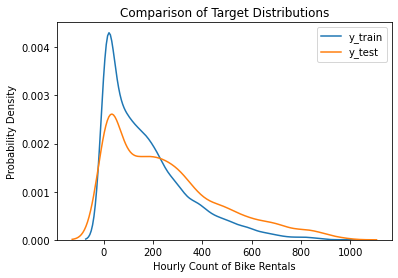

In [12]:
#| code-fold: true
from sklearn.model_selection import train_test_split

data = data.sort_values("dteday", ascending = True)

X = sms.add_constant(data[considered_features])
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    # When shuffle = False, the second part of the dataset is used as the test set.
    shuffle = False,
    test_size = 0.2,
)

# KDE plots
sns.kdeplot(y_train)
sns.kdeplot(y_test)
plt.title("Comparison of Target Distributions")
plt.xlabel("Hourly Count of Bike Rentals")
plt.ylabel("Probability Density")
plt.legend(["y_train", "y_test"])
plt.show()

After the train-test split, it seems that the two sets have roughly similar distributions. Both are right-skewed, as the low values appear frequently and the outliers are high values.

Now, we can use RMSE (Root Mean Squared Error) to evaluate the predictive model.

In [13]:
#| code-fold: true
lr = LinearRegression()
lr.fit(X_train, y_train)

def compare_train_test_rmse(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)

    print(f"Train set: RMSE = {rmse}")

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"Test set: RMSE = {rmse}")

print("Linear Regression")
compare_train_test_rmse(lr, X_train, X_test, y_train, y_test)

Linear Regression
Train set: RMSE = 121.87152363617122
Test set: RMSE = 171.70884445091582


Before I interpret these results, please note the following terminology:

- RMSE: Root Mean Squared Error. It can be interpreted as the average distance of the predicted values from the real values. A lower value indicates better performance.
- Test set RMSE: The RMSE resulting from evaluating the model on the testing set. We use this to assess how well the model performs on previously unseen data.
- Train set RMSE: The RMSE resulting from evaluating the model on the training set. Since the model already saw the training set while it was being trained, this value is not a useful metric of performance. However, it is helpful for determining whether *overfitting* may have occurred.
- Overfitting: The event in which the model has become too sensitive to the small changes in the training data. It is unable to identify the general patterns that help make accurate predictions. If the model performs much worse (higher RMSE) on the test set compared to the training set, this may indicate overfitting.

The test set RMSE is roughly 172, which means that on average, the model's predicted counts of bike rentals were 172 off from the true counts. Let's put that into perspective by looking at the distribution of the target variable.

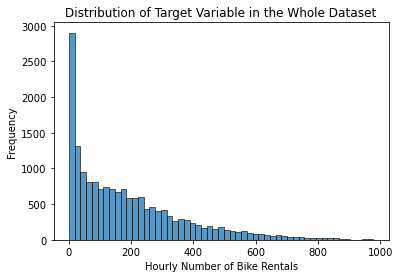

In [14]:
sns.histplot(data = data, x = "cnt")
plt.title("Distribution of Target Variable in the Whole Dataset")
plt.xlabel("Hourly Number of Bike Rentals")
plt.ylabel("Frequency")
plt.show()

The chart shows that the most common values in the distribution range between 0 and 400, and there are some outlying high values.

Let's say that the true value of one observation is equal to 200 bike rentals. Since the RMSE is 172, the predicted value may usually end up being around 28 or 372. Each of these predictions is very low or high given the range of the distribution. Therefore, an RMSE of 172 indicates very poor predictive ability.

Also, the test set RMSE is higher than the train set RMSE by around 50. Thus, the model has somewhat overfitted. It would be better if the test set RMSE is almost as low as the train set RMSE. This would indicate that the model is able to recognize general patterns.

Later on, we'll see how this model compares to the other two models.

# Decision Tree

## A High-Level Explanation

Here, I will briefly explain how decision trees work for regression problems, based on the Dataquest course and some articles by Sriram (2020) and Sayad (2022). Take note of the following terms:

- feature, predictor: A variable used to make a prediction. Multiple features may be used in one model.
- target, response variable: The variable that the model attempts to predict.

Before a DT can make predictions, the tree must first be built. We start with one node, and each node has a conditional statement about a feature. For example, if the feature is temperature, a node may check whether the temperature is lower than 25 degrees Celsius. The "False" case splits off to the left branch, whereas the "True" case splits off to the right branch.

To determine the best feature to use in a split, the model uses an *error metric*. For example, one may use Mean Squared Error, Mean Absolute Error, Standard Deviation, etc. At each split, the model determines the split that will maximize *error reduction*. Reducing the error means reducing the *spread* of the target values, so that the mean value is close to the real values.

The tree keeps splitting nodes and branching off. Eventually, the tree reaches nodes where the error is very low. Thus, these nodes become leaf nodes. The mean target value of each node is used as the predicted value.

When predictions are made on a new observation, the model starts at the root node, checks the conditional statement, moves to the appropriate branch, and repeats this process until a leaf node is reached. Then, the leaf node's predicted value is the output.

The implication is that, unlike linear regression, the model does not assume that there are linear relationships between the predictors and the target. Rather, it narrows down the possible target values through process-of-elimination. Thus, it is able to find **non-linear relationships**. This makes DTs potentially more accurate than linear regression in some scenarios.

## Evaluating a DT Regressor

Let's now create and evaluate a DT regressor. For the features of the model, I decided to use the ones listed below.

In [15]:
considered_features = pd.Series([
    "season",
    "yr",
    "mnth",
    "hr",
    "time_label",
    "holiday",
    "weekday",
    "workingday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed",
])

Earlier, I removed some features due to collinearity issues. However, collinearity is not an issue for Decision Trees because these are not like linear regression. That is why I have not removed the collinear features before performing Decision Tree regression.

Continuing on, let us fit and evaluate the model.

In [16]:
#| code-fold: true
data = data.sort_values("dteday", ascending = True)

X = data[considered_features]
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    # When shuffle = False, the second part of the dataset is used as the test set.
    shuffle = False,
    test_size = 0.2,
)

tree = DecisionTreeRegressor(random_state = 0)

tree.fit(X_train, y_train)

print("Decision Tree")
compare_train_test_rmse(tree, X_train, X_test, y_train, y_test)

Decision Tree
Train set: RMSE = 0.514411456857934
Test set: RMSE = 86.61283689808975


Interestingly, the test set RMSE is now roughly 87. This means that the predicted counts of bike rentals are around 87 away from the true counts. This error value is much lower (and therefore better) than that of the linear regression model shown earlier.

However, the DT model also seems to suffer from overfitting. The test set RMSE is much higher than the train set RMSE (around 0.5).

Thus, we may need to adjust the parameters of the tree to keep it from growing too large. In the code cell below, I have built the tree again, but with constraints on:

- The maximum depth (number of splits from root to leaf nodes)
- The minimum number of samples required to split a node

In [17]:
#| code-fold: true
tree = DecisionTreeRegressor(
    max_depth = 20,
    min_samples_split = 20,
    random_state = 0,
)

tree.fit(X_train, y_train)

print("Decision Tree")
compare_train_test_rmse(tree, X_train, X_test, y_train, y_test)

Decision Tree
Train set: RMSE = 33.94259741687692
Test set: RMSE = 78.39525816583571


These results are slightly better than before. The test set RMSE is around 79, which is better than the previous value of 87. Furthermore, The train set RMSE and test set RMSE are closer to each other, so the model suffers less overfitting.

(Note that the train set RMSE increased. This is not a bad thing; it only means that the model is less sensitive to small variations in the training data.)

Though these results are decent, they can be improved through the use of a Random Forest.

# Random Forest

A Random Forest (RF) is an *ensemble*. This means that it contains multiple individual models. When the ensemble is used to make a prediction, each model first makes its own prediction, then the predictions are combined to make a final prediction. For example, the mean of the models' predictions is taken as the final prediction.

The "Forest" in RF's name refers to the fact that each model in the ensemble is a Decision Tree. The "Random" in RF's name refers to the fact that some random decisions are made while each tree is built, such that each tree is different from the others in the forest.

The processes that introduce randomness are bootstrap aggregation and feature subsets. However, I won't go into detail about how those work. The important point is that since each tree is different, it takes a different *approach* to coming up with a predicted value. By combining varied approaches, we can make a more accurate final prediction.

In the code cell below, I have constructed a Random Forest with 100 Decision Trees.

In [18]:
#| code-fold: true
rf = RandomForestRegressor(
    n_estimators = 100,
    max_depth = 30,
    min_samples_split = 15,
    random_state = 0,
    bootstrap = True,
)

rf.fit(X_train, y_train)

print("Random Forest")
compare_train_test_rmse(rf, X_train, X_test, y_train, y_test)

Random Forest
Train set: RMSE = 29.62524751679492
Test set: RMSE = 70.73988695365036


Now, the test set RMSE is around 71, and this is better than the previous value of 78.

Therefore, using a Random Forest provided an advantage over just one Decision Tree. Note, however, that the Random Forest took over 2 seconds to fit, whereas the Decision Tree took less than a second. As the number of trees in the forest increases, the amount of time required for fitting also increases. One must consider this tradeoff in order to save time and make an accurate model.

# Summary

In summary, we compared the performance of these three models in predicting the number of bike rentals that may occur during a particular hour.

- Linear Regression had the poorest performance. The model only explained 46.3% of the variance in the data, and the test set RMSE was around 172. It also seemed to be overfit.
- The Decision Tree initially suffered from much overfitting, but it performed better when restrictions on the size of the tree were put into place. The test set RMSE was around 78.
- The Random Forest with 100 trees was the best-performing model. The test set RMSE was around 71.

It is important to compare the RMSEs of a model when evaluated on the training set and the testing set so that potential overfitting can be identified and addressed. Decision Trees can be more accurate than Linear Regression because trees can find non-linear relationships. Random Forests can be more accurate than a single Decision Tree because forests combine the predictions of multiple models together.

Thanks for reading!

# Bibliography

## Data Source

Fanaee-T, H. (2013, December 20). Bike Sharing Dataset. UCI Machine Learning Repository. http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

## Information Sources

Dataquest. (n.d.). Guided Project: Predicting Bike Rentals. Dataquest. https://app.dataquest.io/c/22/m/213/guided-project%3A-predicting-bike-rentals/1/introduction-to-the-dataset

Sayad, S. (2022). Decision Tree—Regression. SaedSayad.Com. https://saedsayad.com/decision_tree_reg.htm

scikit-learn developers. (2021). Sklearn.tree.DecisionTreeRegressor. Scikit-Learn. https://scikit-learn/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

Sriram, A. (2020, June 5). Decision Tree for Regression—The Recipe. Analytics Vidhya. https://medium.com/analytics-vidhya/decision-tree-for-regression-the-recipe-74f7628b8a0

## Image Source

Mingot, S. (2020, January 14). Photo by Stéphane Mingot on Unsplash. Unsplash. https://unsplash.com/photos/e8msPzLTXxU